In [1]:
import os
import sys
import pandas as pd
import numpy as np
import json
import copy
import itertools
import tensorflow as tf
from data_utils import read_data,get_max_concepts,calStatistics,extend_multi_concepts,id_mapping,save_id2idx,train_test_split,save_dcur,generate_sequences, get_mask_tokens
import pickle
import glob
import matplotlib.pyplot as plt
import time
from model_for_kt import TFTransfoXLModel,TFTransfoXLLMHeadModel,TFTransfoXLMLMHeadModel

from transformers import TransfoXLConfig
from tensorflow.keras.utils import register_keras_serializable




import horovod.tensorflow as hvd


2024-01-07 20:39:25.379776: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-07 20:39:25.903039: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.4/lib64:
2024-01-07 20:39:25.903085: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.4/lib64:
2024-01-07 20:39:25.903090: W tensorflow/compiler/tf2tensorrt/utils/py_uti

In [2]:
# Horovod 초기화
hvd.init()

# GPU 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
    tf.config.experimental.set_visible_devices(gpus[hvd.local_rank()], 'GPU')

2024-01-07 20:39:28.142548: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-07 20:39:28.143354: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-07 20:39:28.152984: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-07 20:39:28.153572: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-07 20:39:28.154101: I tensorflow/compiler/xla/stream_executo

In [3]:

config_xl = TransfoXLConfig(
    data = '/home/jun/workspace/KT/data/ednet/data.txt',
    dataset = 'wt103',
    d_embed=128,
    d_head = 32,
    d_model=128,
    mem_len=400,
    n_head=8,
    n_layer=6,
    batch_size = 65,
    tgt_len = 140,
    ext_len = 0,
    eval_tgt_len = 36,
    eos_token=2,
    num_c=123,
    mask_token=3,
    C_vocab_size=123,
    R_vocab_size = 2
)

In [4]:

train_path = '/home/jun/workspace/KT/data/ednet/train.csv'

test_path = '/home/jun/workspace/KT/data/ednet/test.csv'

if not os.path.exists(train_path):
    
    # read txt dataset to dataframe
    ALL_KEYS = ["fold", "uid", "questions", "concepts", "responses", "timestamps",
                "usetimes", "selectmasks", "is_repeat", "qidxs", "rest", "orirow", "cidxs"]
    ONE_KEYS = ["fold", "uid"]
    
    total_df, effective_keys = read_data(config_xl.data)
    
    stares = []
    
    if 'concepts' in effective_keys:
        max_concepts = get_max_concepts(total_df)
    else:
        max_concepts = -1
    
    oris, _, qs, cs, seqnum = calStatistics(total_df, stares, "original")
    print("="*20)
    print(
        f"original total interactions: {oris}, qs: {qs}, cs: {cs}, seqnum: {seqnum}")
    
    
    # questions ,concepts 값들의 숫자를 재정의 하여 0~ 나오도록 만들 면서 is_repeat값 처리
    total_df, effective_keys = extend_multi_concepts(total_df, effective_keys)
    total_df, dkeyid2idx = id_mapping(total_df)
    dkeyid2idx["max_concepts"] = max_concepts
    
    extends, _, qs, cs, seqnum = calStatistics(
        total_df, stares, "extend multi")
    print("="*20)
    print(
        f"after extend multi, total interactions: {extends}, qs: {qs}, cs: {cs}, seqnum: {seqnum}")
    
    
    #train test 분리
    train_df, test_df = train_test_split(total_df, 0.2)
    
    train_df.to_csv(train_path,index=False)
    test_df.to_csv(test_path,index=False)
    

delete bad stu num of len: 7, delete interactions: 11, of r: 0, good num: 6162174
original total interactions: 6162174, qs: 12102, cs: 188, seqnum: 4990
df.columns: Index(['uid', 'is_repeat', 'questions', 'responses', 'usetimes', 'concepts',
       'timestamps'],
      dtype='object')
after extend multi, total interactions: 15220330, qs: 12102, cs: 188, seqnum: 4990
total num: 4990, train+valid num: 3992, test num: 998


In [5]:
# def make_eval_mask(R,mask_token,mlm_probability=0.15):
#     labels = tf.identity(R)
        
#     # 기존 probability_matrix 생성
#     probability_matrix = tf.fill(tf.shape(labels), mlm_probability)
    
#     # special_token_mask 생성
#     special_token_mask = tf.equal(R, 2)
    
#     # probability_matrix에 special_token_mask 적용
#     probability_matrix = tf.where(special_token_mask, 0.0, probability_matrix)
    
#     # 마스킹할 인덱스 생성
#     masked_indices = tf.cast(tf.random.uniform(tf.shape(labels)) < probability_matrix, tf.bool)
    
#     # 마스킹된 모든 인덱스 찾기
#     all_masked_indices = tf.where(masked_indices)[:,0]
    
#     # 마스킹된 인덱스 중 랜덤으로 특정값 선택
#     random_index = tf.random.uniform(shape=(), minval=0, maxval=tf.size(all_masked_indices), dtype=tf.int32)
#     selected_masked_index = tf.cast(tf.gather(all_masked_indices, random_index),dtype=tf.int32)
    
        
#     # Create a mask for all elements after the randomly selected masked index
#     extended_mask = tf.range(tf.size(labels)) > selected_masked_index
#     extended_mask = tf.logical_and(extended_mask, ~special_token_mask)
    
#     # Apply extended mask
#     labels = tf.where(~extended_mask, -100, labels)
#     R = tf.where(extended_mask, mask_token, R)

#     return R, labels
def get_evalmask_token(R, mask_token,eos_token, mlm_probability=0.15):
    labels = tf.identity(R)
    
    # 확률 행렬 생성
    probability_matrix = tf.fill(tf.shape(labels), mlm_probability)
    
    # 특별 토큰에 대한 마스크 생성
    special_token_mask = tf.equal(R, eos_token)
    
    # 확률 행렬에 특별 토큰 마스크 적용
    probability_matrix = tf.where(special_token_mask, 0.0, probability_matrix)
    
    # 마스킹할 인덱스 생성
    masked_indices = tf.cast(tf.random.uniform(tf.shape(labels)) < probability_matrix, tf.bool)
    
    # 모든 마스킹된 인덱스 찾기
    all_masked_indices = tf.where(masked_indices)
    all_masked_indices = all_masked_indices[:, 0]
    
    # 마스킹할 인덱스가 없는 경우, 원래의 R 및 labels 반환
    if tf.size(all_masked_indices) == 0:
        return R, tf.fill(tf.shape(labels), -100)
    
    # 랜덤으로 선택된 마스킹된 인덱스
    random_index = tf.random.uniform(shape=(), minval=0, maxval=tf.size(all_masked_indices), dtype=tf.int32)
    selected_masked_index = tf.cast(tf.gather(all_masked_indices, random_index), dtype=tf.int32)
    
    # 랜덤으로 선택된 마스킹된 인덱스 이후의 모든 요소에 대한 마스크 생성
    extended_mask = tf.range(tf.size(labels)) > selected_masked_index
    extended_mask = tf.logical_and(extended_mask, ~special_token_mask)
    
    # 확장된 마스크 적용
    labels = tf.where(~extended_mask, -100, labels)
    R = tf.where(extended_mask, mask_token, R)

    return R, labels


### DATASET 만들기

In [6]:


class TrainDataGenerator:
    def __init__(self, train_path, bsz, bptt, eos_token, mask_token, ext_len=None):
        self.train_path = train_path.decode('utf-8') if isinstance(train_path, bytes) else train_path
        self.bsz = bsz
        self.bptt = bptt
        self.eos_token = eos_token
        self.mask_token = mask_token
        self.ext_len = ext_len if ext_len is not None else 0
        self.n_step = None
        self.train_df = pd.read_csv(self.train_path)

    
    def generate(self):

        train_df = self.train_df
        #transformer_xl dataset 만들기
        dori = {"qseqs": [], "cseqs": [], "rseqs": []} #"q_shift": [], "c_shift": [], "r_shift": []}
    
        # eos_token= 2 # config 파일로 조정할 수 있도록 수정 할 것!
        # num_c =123 # config 파일로 조정할 수 있도록 수정 할 것!
        for i, row in train_df.iterrows():
        #use kc_id or question_id as input
        
            cseq_list=[int(_) for _ in row["concepts"].split(",")]
            cseq_list.append(self.eos_token)
            dori["cseqs"].append(cseq_list)
    
            qes_list=[int(_) for _ in row["questions"].split(",")]
            qes_list.append(self.eos_token)
            dori["qseqs"].append(qes_list)
    
    
            rseq_list=[(int(_)) for _ in row["responses"].split(",")]
            rseq_list.append(self.eos_token)
            dori["rseqs"].append(rseq_list)
    
            # c_shift_list=[int(_) for _ in row["concepts"].split(",")]
            # c_shift_list.append(eos_token)
            # dori["c_shift"].append(c_shift_list)
    
    
            # r_shift_list=[int(_) for _ in row["responses"].split(",")]
            # r_shift_list.append(eos_token)
            # dori["r_shift"].append(r_shift_list)
    
        '''
        딕셔너리의 각 값마다 끝에 eos 토큰 삽입
        rseqs에는 num_c 곱하여 cseqs 더할 값 만들기
    
        '''
        cseqs_list = list(itertools.chain(*dori['cseqs']))
        qseqs_list = list(itertools.chain(*dori['qseqs']))
        rseqs_list = list(itertools.chain(*dori['rseqs']))
        # c_shift_list = list(itertools.chain(*dori['c_shift']))
        # r_shift_list = list(itertools.chain(*dori['r_shift']))
    
    
        
        
        
        # Work out how cleanly we can divide the dataset into bsz parts.
        # 아래의 두 코드는   data 텐서에서 배치 크기 bsz로 깔끔하게 맞지 않는 추가 요소를 제거하는 것 배치에 띡 떨어지게
        n_step = len(cseqs_list) // (self.bsz*self.bptt)
        print('n_step',n_step) # 
        
        sliced_cseqs = tf.slice(cseqs_list,[0],[n_step * self.bsz*self.bptt])  
        sliced_qseqs = tf.slice(qseqs_list,[0],[n_step * self.bsz*self.bptt])  
        sliced_rseqs = tf.slice(rseqs_list,[0],[n_step * self.bsz*self.bptt]) 


        count =len(sliced_cseqs)// (self.bsz*self.bptt)
        self.n_step = count
        '''# 시작 위치와 슬라이싱할 크기 설정
        begin = [0]  # 첫 번째 차원의 시작 위치는 0
        size = [6]   # 첫 번째 차원에서 6개의 원소를 슬라이싱
    
        # 데이터를 잘라내기 (tf.slice 사용)
        sliced_data = tf.slice(data, begin, size)  '''
    
        # Evenly divide the da
        # ta across the bsz batches.
    
        new_shape = (self.bsz, -1)  # 나머지 차원은 자동으로 계산됨
    
        cseq_reshaped = tf.reshape(sliced_cseqs, new_shape)
        rseq_reshaped = tf.reshape(sliced_rseqs, new_shape)
        # c_shift_reshaped = tf.reshape(sliced_c_shift, new_shape)
        # r_shift_reshaped = tf.reshape(sliced_r_shift, new_shape)
        # data_transposed = tf.transpose(data_reshaped)
        # print('interaction_reshaped',interaction_reshaped.shape)
        split_num = 2 #GPU num
    
    
        # first_half, second_half = tf.split(data, num_or_size_splits=split_num, axis=1)
    
        n_batch = (n_step + self.bptt - 1) // self.bptt
    
        for i in range(0, len(rseq_reshaped[1]) - 1, self.bptt):
            
            seq_len = min(self.bptt, rseq_reshaped.shape[1] - 1 - i) # # i값이 103227020를 넘지 않는 이상 seq_len = 70
    
    
            end_idx = i + seq_len # 70,71,72,73,74......
            beg_idx = max(0, i - self.ext_len) # 0,1,2,3,4,5
            ''' 아래 처럼 첫번째 차원을 자르는 이류
            로,또,1,등,당,첨 = > 로,또,1    => 로, 등
                            등,당,첨         또, 당
                                            1, 첨
            '''
    
            C = cseq_reshaped[:,beg_idx:end_idx] # self.data[:,0:70],[:,1:71] ~
            R = rseq_reshaped[:,beg_idx:end_idx] # self.data[:,0:70],[:,1:71] ~
            # label = rseq_reshaped[:,beg_idx:end_idx] # self.data[:,0:70],[:,1:71] ~
            # Query = c_shift_reshaped[:,i+1:i+1+seq_len] # self.data[:,0:70],[:,1:71] ~
            # r_shift = r_shift_reshaped[:,i+1:i+1+seq_len]
    
            # second_half_data = second_half[:,beg_idx:end_idx] # self.data[:,0:70],[:,1:71] ~
            # second_half_target = second_half[:,i+1:i+1+seq_len]
            '''
            여기서 원하는 값을 마스킹 해주도록 하자!
            '''
            masked_R, labels = get_mask_tokens(R,self.mask_token)
    
    
            if i + self.bptt < len(rseq_reshaped[1]) - 1:
                yield C, masked_R,labels
            # yield second_half_data, second_half_target

    def get_n_step(self):
        return self.n_step


In [30]:

class TestDataGenerator:
    def __init__(self, test_path, bsz, bptt, eos_token, mask_token, ext_len=None):
        self.test_path = test_path.decode('utf-8') if isinstance(test_path, bytes) else test_path
        self.bsz = bsz
        self.bptt = bptt
        self.eos_token = eos_token
        self.mask_token = mask_token
        self.ext_len = ext_len if ext_len is not None else 0
        self.n_step = None
        self.test_df = pd.read_csv(self.test_path)

    def generate(self):
        
        #transformer_xl dataset 만들기
        dori = {"qseqs": [], "cseqs": [], "r_mask_seqs": [], "labels":[]} #"q_shift": [], "c_shift": [], "r_shift": []}
        test_df =self.test_df
    
        # eos_token= 2 # config 파일로 조정할 수 있도록 수정 할 것!
        # num_c =123 # config 파일로 조정할 수 있도록 수정 할 것!
        for i, row in test_df.iterrows():
        #use kc_id or question_id as input
        
            cseq_list=[int(_) for _ in row["concepts"].split(",")]
            cseq_list.append(self.eos_token)   
            dori["cseqs"].append(cseq_list)
    
            qes_list=[int(_) for _ in row["questions"].split(",")]
            qes_list.append(self.eos_token)
            dori["qseqs"].append(qes_list)
    
    
            rseq_list=[(int(_)) for _ in row["responses"].split(",")]
            rseq_list.append(self.eos_token)
            masked_R, labels = get_evalmask_token(rseq_list, self.mask_token,self.eos_token)
            
            dori["r_mask_seqs"].append(masked_R)
            dori["labels"].append(labels)
    
            # c_shift_list=[int(_) for _ in row["concepts"].split(",")]
            # c_shift_list.append(eos_token)
            # dori["c_shift"].append(c_shift_list)
    
    
            # r_shift_list=[int(_) for _ in row["responses"].split(",")]
            # r_shift_list.append(eos_token)
            # dori["r_shift"].append(r_shift_list)
    
        '''
        딕셔너리의 각 값마다 끝에 eos 토큰 삽입
        rseqs에는 num_c 곱하여 cseqs 더할 값 만들기
    
        '''
        cseqs_list = list(itertools.chain(*dori['cseqs']))
        qseqs_list = list(itertools.chain(*dori['qseqs']))
        r_masked_list = tf.concat(dori['r_mask_seqs'], axis=0)
        labels = tf.concat(dori['labels'], axis=0)

        print('cseqs_list',len(cseqs_list))
        print('r_masked_list',r_masked_list.shape)
    
        
        # Work out how cleanly we can divide the dataset into bsz parts.
        # 아래의 두 코드는   data 텐서에서 배치 크기 bsz로 깔끔하게 맞지 않는 추가 요소를 제거하는 것 배치에 띡 떨어지게
            
        n_step = len(cseqs_list) // (self.bsz*self.bptt)
        print('n_step',n_step) # 
        
        sliced_cseqs = tf.slice(cseqs_list,[0],[n_step * self.bsz * self.bptt])  
        sliced_qseqs = tf.slice(qseqs_list,[0],[n_step * self.bsz * self.bptt])  
        sliced_r_masked_seq = tf.slice(r_masked_list,[0],[n_step * self.bsz * self.bptt])  
        sliced_labels = tf.slice(labels,[0],[n_step * self.bsz * self.bptt])  
        
        print('sliced_cseqs',sliced_cseqs.shape)
        print('sliced_r_masked_seq',sliced_r_masked_seq.shape)




        count =len(sliced_cseqs)// (self.bsz*self.bptt)
        print(count)
        self.n_step = count
        '''# 시작 위치와 슬라이싱할 크기 설정
        begin = [0]  # 첫 번째 차원의 시작 위치는 0
        size = [6]   # 첫 번째 차원에서 6개의 원소를 슬라이싱
    
        # 데이터를 잘라내기 (tf.slice 사용)
        sliced_data = tf.slice(data, begin, size)  '''
    
        # Evenly divide the da
        # ta across the bsz batches.
    
        new_shape = (self.bsz, -1)  # 나머지 차원은 자동으로 계산됨
        
        cseq_reshaped = tf.reshape(sliced_cseqs, new_shape)
        r_masked_seq_reshaped = tf.reshape(sliced_r_masked_seq, new_shape)
        labels_reshaped = tf.reshape(sliced_labels, new_shape)
        split_num = 2 #GPU num

        print('labels_reshaped',labels_reshaped.shape)
        
        
        # first_half, second_half = tf.split(data, num_or_size_splits=split_num, axis=1)
        
        
        for i in range(0, r_masked_seq_reshaped.shape[1] - 1, self.bptt):
            
            seq_len = min(self.bptt, r_masked_seq_reshaped.shape[1] - 1 - i) # # i값이 103227020를 넘지 않는 이상 seq_len = 70
        
        
            end_idx = i + seq_len # 70,71,72,73,74......
            beg_idx = max(0, i - self.ext_len) # 0,1,2,3,4,5
            ''' 아래 처럼 첫번째 차원을 자르는 이류
            로,또,1,등,당,첨 = > 로,또,1    => 로, 등
                            등,당,첨         또, 당
                                            1, 첨
            '''
        
            C = cseq_reshaped[:,beg_idx:end_idx] # self.data[:,0:70],[:,1:71] ~
            masked_R = r_masked_seq_reshaped[:,beg_idx:end_idx] # self.data[:,0:70],[:,1:71] ~
            labels = labels_reshaped[:,beg_idx:end_idx] # self.data[:,0:70],[:,1:71] ~
    
    
            if i + self.bptt < len(r_masked_seq_reshaped[1]) - 1:
                yield C, masked_R,labels
            # yield second_half_data, second_half_target

    def get_n_step(self):
        return self.n_step


In [36]:
count =0
for i in range(0, 47879, 140):
    count += 1
print(count)

342


In [31]:
train_gen_obj = TrainDataGenerator(train_path,
     config_xl.batch_size,
     config_xl.tgt_len,
     config_xl.eos_token,
     config_xl.mask_token
)

test_gen_obj = TestDataGenerator(
    test_path,
     config_xl.batch_size,
     config_xl.tgt_len,
     config_xl.eos_token,
     config_xl.mask_token
)

In [32]:
train_dataset = tf.data.Dataset.from_generator(
     train_gen_obj.generate,
     output_signature=(
         tf.TensorSpec(shape=None, dtype=tf.int64),
         tf.TensorSpec(shape=None, dtype=tf.int64),
         tf.TensorSpec(shape=None, dtype=tf.int64),
         ),
         )
test_dataset = tf.data.Dataset.from_generator(
     test_gen_obj.generate,
     output_signature=(
         tf.TensorSpec(shape=None, dtype=tf.int64),
         tf.TensorSpec(shape=None, dtype=tf.int64),
         tf.TensorSpec(shape=None, dtype=tf.int64),
         )
         )

In [33]:
A = next(iter(test_dataset))

test_count = test_gen_obj.get_n_step()
test_count

cseqs_list 3112466
r_masked_list (3112466,)
n_step 342
sliced_cseqs (3112200,)
sliced_r_masked_seq (3112200,)
342
labels_reshaped (65, 47880)


342

In [37]:

test_first_half_dataset = test_dataset.take(test_count//2)
test_second_half_dataset = test_dataset.skip((test_count // 2) + (test_count % 2))

In [41]:
for A,B,C in test_first_half_dataset:
    A
    B
    print(C.shape)


cseqs_list 3112466
r_masked_list (3112466,)
n_step 342
sliced_cseqs (3112200,)
sliced_r_masked_seq (3112200,)
342
labels_reshaped (65, 47880)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140)
(65, 140

In [58]:
train_count = train_gen_obj.get_n_step()
test_count = test_gen_obj.get_n_step()


train_first_half_dataset = train_dataset.take(train_count//2)
train_second_half_dataset = train_dataset.skip((train_count // 2) + (train_count % 2))

test_first_half_dataset = test_dataset.take(test_count//2)
test_second_half_dataset = test_dataset.skip((test_count // 2) + (test_count % 2))


In [7]:
# def create_masked_language_xl_model(xl_model):
    
#     # Input layer
#     inputs = tf.keras.layers.Input((config_xl.MAX_LEN,), dtype=tf.int64)

#     # Word embedding layer
#     word_embeddings = tf.keras.layers.Embedding(config_xl.VOCAB_SIZE, config_xl.EMBED_DIM, name="word_embedding")(inputs)
    
#     # Position embedding layer
#     position_embeddings = tf.keras.layers.Embedding(input_dim=config_xl.MAX_LEN,
#                                                     output_dim=vars.EMBED_DIM,
#                                                     weights=[get_pos_encoding_matrix(config_xl.MAX_LEN, config_xl.EMBED_DIM)],
#                                                     name="position_embedding",
#                                                     )(tf.range(start=0, limit=config_xl.MAX_LEN, delta=1))
    
#     # Add the word and position embeddings
#     embeddings = word_embeddings + position_embeddings

#     # Get the output of the embedding layer
#     encoder_output = embeddings
    
#     # Loop over the number of layers
#     for i in range(config.NUM_LAYERS):
        
#         # Create BERT module
#         encoder_output = xl_model(encoder_output, encoder_output, encoder_output, i)

#     # Output layer
#     mlm_output = tf.keras.layers.Dense(config.VOCAB_SIZE, name="mlm_cls", activation="softmax")(encoder_output)
    
#     # MLM model
#     mlm_model = MaskedLanguageModel(inputs, mlm_output, name="masked_bert_model")

#     # Adam optimizer
#     optimizer = tf.keras.optimizers.Adam(learning_rate=config.LR)
    
#     # Compile the model
#     mlm_model.compile(optimizer=optimizer)
    
#     return mlm_model

In [7]:

@register_keras_serializable()
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)

        self.warmup_steps = tf.cast(warmup_steps,tf.float32)

    def __call__(self, step):
        step =tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
    
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)*hvd.size()
    
    def get_config(self):
        return {
            'd_model': self.d_model,
            'warmup_steps': self.warmup_steps
            }
learning_rate = CustomSchedule(config_xl.d_model)



해야할 것 정리


모델 모아져 있는 곳 같서 새로운 클래스 하나 만들고 거기에다가
https://github.com/soheil-mp/BERT/blob/main/BERT-MLM.ipynb
여기서 나오는 부분 확인하고 끝부분 코드랑 loss 구하는거 갓다 밖아서 lml모델 되게 만들기가 먼저다 내일!!!

In [8]:

# CustomSchedule 및 모델 정의는 이전과 동일하게 유지합니다.
# ...

# 옵티마이저 정의 및 Horovod 래핑
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
optimizer = hvd.DistributedOptimizer(optimizer)

# 모델 정의

# 모델 및 데이터셋 생성
if hvd.rank() == 0:
    model0 = TFTransfoXLMLMHeadModel(config=config_xl)
  # GPU:0에서 사용할 첫 번째 모델
    dataset0 = first_half_dataset       # 첫 번째 데이터셋
    mems0 = None              # 첫 번째 모델의 메모리 상태
elif hvd.rank() == 1:
    model1 = TFTransfoXLMLMHeadModel(config=config_xl)
  # GPU:1에서 사용할 두 번째 모델
    dataset1 = second_half_dataset       # 두 번째 데이터셋
    mems1 = None              # 두 번째 모델의 메모리 상태

In [10]:
from tensorflow import keras
# 훈련 스텝 정의
@tf.function
def train_step(model, data1,data2, target, mems, optimizer,first_batch):
    with tf.GradientTape() as tape:
        outputs = model(concepts=data1,responses=data2, labels=target, mems=mems)
        loss = outputs.loss
        mems = outputs.mems

        loss_mx = target != -100
        loss_value = loss[loss_mx]
        loss_value = tf.reshape(loss_value, [-1, config_xl.R_vocab_size])
        labels = target[loss_mx]
        label = tf.reshape(labels, [-1])    

        # valid_samples = tf.reduce_sum(tf.cast(loss_mx, tf.float32))

        # tf.print('loss_mx',loss_mx)
        # tf.print('valid_samples',valid_samples)

        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=loss_value)

        # batch_loss = tf.reduce_sum(loss) / valid_samples
        mean_loss = tf.reduce_mean(loss)

    # Horovod: add Horovod Distributed GradientTape.
    tape = hvd.DistributedGradientTape(tape)

    gradients = tape.gradient(mean_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if first_batch:
        hvd.broadcast_variables(model.variables, root_rank=0)
        hvd.broadcast_variables(optimizer.variables(), root_rank=0)

    return mems,mean_loss


    return mems, loss

In [ ]:

loss_values = []  # 각 배치의 손실 값을 저장할 리스트

for epoch in range(2):
    start = time.time()
    num_batches = 0
    total_loss = 0.0
    if hvd.rank() == 0:
        for data1, data2, target in dataset0:
            mems0, loss_value = train_step(model0, data1,data2, target, mems0, optimizer,num_batches==0)
            # print('loss_value',loss_value)
            num_batches += 1
            total_loss += loss_value.numpy()
            if num_batches % 100 == 0:
                loss_values.append(loss_value.numpy())
                print(f'Epoch {epoch + 1} Batch {num_batches} Loss {loss_value.numpy()}')
    elif hvd.rank() == 1:
        for data1,data2, target in dataset1:
            mems1, loss_value = train_step(model1, data1,data2, target, mems1, optimizer,num_batches==0)
            num_batches += 1
            total_loss += loss_value.numpy()
            if num_batches % 100 == 0:
                print(f'Epoch {epoch + 1} Batch {num_batches} Loss {loss_value.numpy()}')

delete bad stu num of len: 7, delete interactions: 11, of r: 0, good num: 6162174
original total interactions: 6162174, qs: 12102, cs: 188, seqnum: 4990
df.columns: Index(['uid', 'is_repeat', 'usetimes', 'concepts', 'responses', 'timestamps',
       'questions'],
      dtype='object')
after extend multi, total interactions: 15220330, qs: 12102, cs: 188, seqnum: 4990
total num: 4990, train+valid num: 3992, test num: 998
n_step 67293
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2024-01-04 15:01:31.996440: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f10521bc550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-04 15:01:31.996462: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
2024-01-04 15:01:31.999740: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-04 15:01:32.078355: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1 Batch 100 Loss 0.5106260180473328
Epoch 1 Batch 200 Loss 0.4236483573913574
Epoch 1 Batch 300 Loss 0.7826365232467651
Epoch 1 Batch 400 Loss 0.6542941927909851
Epoch 1 Batch 500 Loss 0.6501874327659607
Epoch 1 Batch 600 Loss 0.23265719413757324
Epoch 1 Batch 700 Loss 0.3686043620109558
Epoch 1 Batch 800 Loss 0.1799973100423813
Epoch 1 Batch 900 Loss 0.3789503872394562
Epoch 1 Batch 1000 Loss 0.29987332224845886
Epoch 1 Batch 1100 Loss 0.2906081974506378
Epoch 1 Batch 1200 Loss 0.13314129412174225
Epoch 1 Batch 1300 Loss 0.11833824217319489
Epoch 1 Batch 1400 Loss 0.11459559202194214
Epoch 1 Batch 1500 Loss 0.10309137403964996
Epoch 1 Batch 1600 Loss 0.42019402980804443
Epoch 1 Batch 1700 Loss 0.1580684930086136
Epoch 1 Batch 1800 Loss 0.12438607215881348
Epoch 1 Batch 1900 Loss 0.23035138845443726
Epoch 1 Batch 2000 Loss 0.4695955514907837
Epoch 1 Batch 2100 Loss 0.2967666685581207
Epoch 1 Batch 2200 Loss 0.04822107404470444
Epoch 1 Batch 2300 Loss 0.34239640831947327
Epoch 1 B

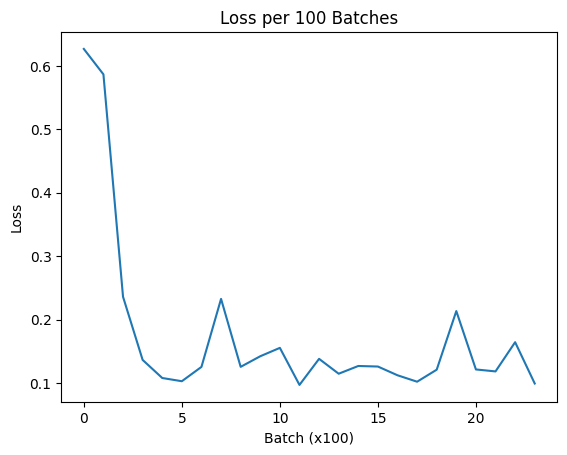

In [2]:
import csv
import matplotlib.pyplot as plt

# Read loss values from the CSV file
loss_values = []
with open('/home/jun/workspace/KT/loss/loss_values.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row
    for row in reader:
        loss_values.append(float(row[1]))  # Assuming the loss value is in the second column

# Plot the graph
plt.plot(loss_values)
plt.xlabel('Batch (x100)')
plt.ylabel('Loss')
plt.title('Loss per 100 Batches')
plt.show()

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import json
import copy
import itertools
import tensorflow as tf
from data_utils import read_data,get_max_concepts,calStatistics,extend_multi_concepts,id_mapping,save_id2idx,train_test_split,save_dcur,generate_sequences, get_mask_tokens
import pickle
import glob
import matplotlib.pyplot as plt
import time
from model_for_kt import TFTransfoXLModel,TFTransfoXLLMHeadModel,TFTransfoXLMLMHeadModel

from transformers import TransfoXLConfig
from tensorflow.keras.utils import register_keras_serializable
import datetime




2024-01-11 16:01:09.470556: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 16:01:10.056267: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.4/lib64:
2024-01-11 16:01:10.056324: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.4/lib64:
2024-01-11 16:01:10.056330: W tensorflow/compiler/tf2tensorrt/utils/py_uti

In [3]:

config_xl = TransfoXLConfig(
    data = '/home/jun/workspace/KT/data/ednet/data.txt',
    dataset = 'wt103',
    d_embed=128,
    d_head = 32,
    d_model=128,
    mem_len=400,
    n_head=8,
    n_layer=6,
    batch_size = 65,
    tgt_len = 140,
    ext_len = 0,
    eval_tgt_len = 36,
    eos_token=2,
    num_c=123,
    mask_token=3,
    C_vocab_size=188,
    R_vocab_size = 2
)

In [4]:

def get_evalmask_token(R, mask_token,eos_token, mlm_probability=0.15):
    labels = tf.identity(R)
    
    # 확률 행렬 생성
    probability_matrix = tf.fill(tf.shape(labels), mlm_probability)
    
    # 특별 토큰에 대한 마스크 생성
    special_token_mask = tf.equal(R, eos_token)
    
    # 확률 행렬에 특별 토큰 마스크 적용
    probability_matrix = tf.where(special_token_mask, 0.0, probability_matrix)
    
    # 마스킹할 인덱스 생성
    masked_indices = tf.cast(tf.random.uniform(tf.shape(labels)) < probability_matrix, tf.bool)
    
    # 모든 마스킹된 인덱스 찾기
    all_masked_indices = tf.where(masked_indices)
    all_masked_indices = all_masked_indices[:, 0]
    
    # 마스킹할 인덱스가 없는 경우, 원래의 R 및 labels 반환
    if tf.size(all_masked_indices) == 0:
        return R, tf.fill(tf.shape(labels), -100)
    
    # 랜덤으로 선택된 마스킹된 인덱스
    random_index = tf.random.uniform(shape=(), minval=0, maxval=tf.size(all_masked_indices), dtype=tf.int32)
    selected_masked_index = tf.cast(tf.gather(all_masked_indices, random_index), dtype=tf.int32)
    
    # 랜덤으로 선택된 마스킹된 인덱스 이후의 모든 요소에 대한 마스크 생성
    extended_mask = tf.range(tf.size(labels)) > selected_masked_index
    extended_mask = tf.logical_and(extended_mask, ~special_token_mask)
    
    # 확장된 마스크 적용
    labels = tf.where(~extended_mask, -100, labels)
    R = tf.where(extended_mask, mask_token, R)

    return R, labels


In [5]:


ALL_KEYS = ["fold", "uid", "questions", "concepts", "responses", "timestamps",
            "usetimes", "selectmasks", "is_repeat", "qidxs", "rest", "orirow", "cidxs"]
ONE_KEYS = ["fold", "uid"]

total_df, effective_keys = read_data('/home/jun/workspace/KT/data/ednet/data.txt')

stares = []

if 'concepts' in effective_keys:
    max_concepts = get_max_concepts(total_df)
else:
    max_concepts = -1

oris, _, qs, cs, seqnum = calStatistics(total_df, stares, "original")
print("="*20)
print(
    f"original total interactions: {oris}, qs: {qs}, cs: {cs}, seqnum: {seqnum}")


# questions ,concepts 값들의 숫자를 재정의 하여 0~ 나오도록 만들 면서 is_repeat값 처리
# 14_54_14 으로 된 concepts를 14,54,14 로 분리하고 기존의 response도 똑같이 확장처리
total_df_ex, effective_keys = extend_multi_concepts(total_df, effective_keys)
total_df, dkeyid2idx = id_mapping(total_df_ex)
dkeyid2idx["max_concepts"] = max_concepts

extends, _, qs, cs, seqnum = calStatistics(
    total_df, stares, "extend multi")
print("="*20)
print(
    f"after extend multi, total interactions: {extends}, qs: {qs}, cs: {cs}, seqnum: {seqnum}")


#train test 분리
train_df, test_df = train_test_split(total_df, 0.2)

#transformer_xl dataset 만들기
train = {"qseqs": [], "cseqs": [], "masked_R": [], "labels": []} #"q_shift": [], "c_shift": [], "r_shift": []}
test = {"qseqs": [], "cseqs": [], "masked_R": [], "labels": []} #"q_shift": [], "c_shift": [], "r_shift": []}


delete bad stu num of len: 7, delete interactions: 11, of r: 0, good num: 6162174
original total interactions: 6162174, qs: 12102, cs: 188, seqnum: 4990
df.columns: Index(['uid', 'is_repeat', 'timestamps', 'concepts', 'questions', 'responses',
       'usetimes'],
      dtype='object')
after extend multi, total interactions: 15220330, qs: 12102, cs: 188, seqnum: 4990
total num: 4990, train+valid num: 3992, test num: 998


In [6]:

# eos_token= 2 # config 파일로 조정할 수 있도록 수정 할 것!
# num_c =123 # config 파일로 조정할 수 있도록 수정 할 것!
for i, row in train_df.iterrows():
#use kc_id or question_id as input

    cseq_list=[int(_) for _ in row["concepts"].split(",")]
    cseq_list.append(config_xl.eos_token)
    train["cseqs"].append(cseq_list)

    qes_list=[int(_) for _ in row["questions"].split(",")]
    qes_list.append(config_xl.eos_token)
    train["qseqs"].append(qes_list)


    rseq_list=[(int(_)) for _ in row["responses"].split(",")]
    rseq_list.append(config_xl.eos_token)
    masked_R, labels = get_mask_tokens(rseq_list,config_xl.mask_token)
    train["masked_R"].append(masked_R)
    train["labels"].append(labels)
for i, row in test_df.iterrows():
    #use kc_id or question_id as input
    
        cseq_list=[int(_) for _ in row["concepts"].split(",")]
        cseq_list.append(config_xl.eos_token)   
        test["cseqs"].append(cseq_list)

        qes_list=[int(_) for _ in row["questions"].split(",")]
        qes_list.append(config_xl.eos_token)
        test["qseqs"].append(qes_list)


        rseq_list=[(int(_)) for _ in row["responses"].split(",")]
        rseq_list.append(config_xl.eos_token)
        masked_R, labels = get_evalmask_token(rseq_list, config_xl.mask_token, config_xl.eos_token)
        
        test["masked_R"].append(masked_R)
        test["labels"].append(labels)

2024-01-11 16:02:14.466464: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-11 16:02:14.466696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-11 16:02:14.472258: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-11 16:02:14.472506: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-11 16:02:14.472797: I tensorflow/compiler/xla/stream_executo

In [14]:
#train
cseqs_list = list(itertools.chain(*train['cseqs']))
qseqs_list = list(itertools.chain(*train['qseqs']))
r_masked_list = tf.concat(train['masked_R'], axis=0)
labels = tf.concat(train['labels'], axis=0)

n_step = len(cseqs_list) // (config_xl.batch_size*config_xl.tgt_len)
print('n_step',n_step)

sliced_cseqs = tf.slice(cseqs_list,[0],[n_step * config_xl.batch_size*config_xl.tgt_len])  
sliced_qseqs = tf.slice(qseqs_list,[0],[n_step * config_xl.batch_size*config_xl.tgt_len])  
sliced_r_mask = tf.slice(r_masked_list,[0],[n_step * config_xl.batch_size*config_xl.tgt_len]) 
sliced_labels = tf.slice(labels,[0],[n_step * config_xl.batch_size*config_xl.tgt_len]) 

count =len(sliced_cseqs)// (config_xl.batch_size*config_xl.tgt_len)

new_shape = (config_xl.batch_size, -1)  # 나머지 차원은 자동으로 계산됨

cseq_reshaped = tf.reshape(sliced_cseqs, new_shape)
r_mask_reshaped = tf.reshape(sliced_r_mask, new_shape)
labels_reshaped = tf.reshape(sliced_labels, new_shape)

cseq_transposed = tf.transpose(cseq_reshaped)
r_mask_transposed = tf.transpose(r_mask_reshaped)
labels_transposed = tf.transpose(labels_reshaped)


#test
test_cseqs_list = list(itertools.chain(*test['cseqs']))
test_qseqs_list = list(itertools.chain(*test['qseqs']))
test_r_masked_list = tf.concat(test['masked_R'], axis=0)
test_labels = tf.concat(test['labels'], axis=0)



# Work out how cleanly we can divide the dataset into bsz parts.
# 아래의 두 코드는   data 텐서에서 배치 크기 bsz로 깔끔하게 맞지 않는 추가 요소를 제거하는 것 배치에 띡 떨어지게
    
test_n_step = len(test_cseqs_list) // (config_xl.batch_size*config_xl.tgt_len)
print('n_step',test_n_step) # 

test_sliced_cseqs = tf.slice(test_cseqs_list,[0],[test_n_step * config_xl.batch_size*config_xl.tgt_len])  
test_sliced_qseqs = tf.slice(test_qseqs_list,[0],[test_n_step * config_xl.batch_size*config_xl.tgt_len])  
test_sliced_r_masked_seq = tf.slice(test_r_masked_list,[0],[test_n_step * config_xl.batch_size*config_xl.tgt_len]) 

test_sliced_labels = tf.slice(test_labels,[0],[test_n_step * config_xl.batch_size*config_xl.tgt_len])  

count =len(test_sliced_cseqs)// (config_xl.batch_size*config_xl.tgt_len)
print(count)

'''# 시작 위치와 슬라이싱할 크기 설정
begin = [0]  # 첫 번째 차원의 시작 위치는 0
size = [6]   # 첫 번째 차원에서 6개의 원소를 슬라이싱

# 데이터를 잘라내기 (tf.slice 사용)
sliced_data = tf.slice(data, begin, size)  '''

# Evenly divide the da
# ta across the bsz batches.

new_shape = (config_xl.batch_size, -1)  # 나머지 차원은 자동으로 계산됨

test_cseq_reshaped = tf.reshape(test_sliced_cseqs, new_shape)
test_r_masked_seq_reshaped = tf.reshape(test_sliced_r_masked_seq, new_shape)
test_labels_reshaped = tf.reshape(test_sliced_labels, new_shape)


test_cseq_reshaped = tf.transpose(test_cseq_reshaped)
test_r_masked_seq_reshaped = tf.transpose(test_r_masked_seq_reshaped)
test_labels_reshaped = tf.cast(tf.transpose(test_labels_reshaped),tf.int64)


n_step 1331


2024-01-11 16:06:26.666292: W tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 46.20MiB (rounded to 48448512)requested by op Transpose
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-01-11 16:06:26.666985: I tensorflow/tsl/framework/bfc_allocator.cc:1034] BFCAllocator dump for GPU_0_bfc
2024-01-11 16:06:26.667030: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (256): 	Total Chunks: 869, Chunks in use: 866. 217.2KiB allocated for chunks. 216.5KiB in use in bin. 96.0KiB client-requested in use in bin.
2024-01-11 16:06:26.667057: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (512): 	Total Chunks: 814, Chunks in use: 811. 509.5KiB allocated for chunks. 508.0KiB in use in bin. 379.1KiB client-requested in use in bin.
2024-01-11 16:06:26.667081: I tensorflow/ts

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run Transpose: Dst tensor is not initialized. [Op:Transpose]

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (cseq_transposed, r_mask_transposed, labels_transposed))
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_cseq_reshaped, test_r_masked_seq_reshaped, test_labels_reshaped))

In [9]:
train_dataset =train_dataset.batch(config_xl.tgt_len)
test_dataset =test_dataset.batch(config_xl.tgt_len)

In [13]:
A = next(iter(test_dataset))
A

(<tf.Tensor: shape=(140, 65), dtype=int32, numpy=
 array([[121,  54,  62, ...,  77,  27,  13],
        [ 27,  55,  43, ...,   8,  34,  91],
        [ 31,  56,   8, ...,  83,  35, 124],
        ...,
        [ 25,   9,  46, ...,  43, 119,  29],
        [ 30,   8,  47, ...,  47,  94,  35],
        [ 16,  77, 148, ...,  61, 147,  29]], dtype=int32)>,
 <tf.Tensor: shape=(140, 65), dtype=int32, numpy=
 array([[1, 0, 3, ..., 3, 1, 0],
        [0, 0, 3, ..., 3, 0, 1],
        [1, 0, 3, ..., 3, 1, 1],
        ...,
        [0, 1, 1, ..., 3, 3, 1],
        [0, 1, 1, ..., 3, 3, 1],
        [0, 1, 1, ..., 3, 3, 1]], dtype=int32)>,
 <tf.Tensor: shape=(140, 65), dtype=int64, numpy=
 array([[-100, -100,    0, ...,    0, -100, -100],
        [-100, -100,    0, ...,    0, -100, -100],
        [-100, -100,    0, ...,    0, -100, -100],
        ...,
        [-100, -100, -100, ...,    0,    0, -100],
        [-100, -100, -100, ...,    0,    1, -100],
        [-100, -100, -100, ...,    1,    0, -100]])>)

In [10]:
test_first_half_dataset = test_dataset.take(342//2)
test_second_half_dataset = test_dataset.skip((342 // 2) + (342 % 2))

In [11]:
A = next(iter(test_first_half_dataset))
A

(<tf.Tensor: shape=(140, 65), dtype=int32, numpy=
 array([[121,  54,  62, ...,  77,  27,  13],
        [ 27,  55,  43, ...,   8,  34,  91],
        [ 31,  56,   8, ...,  83,  35, 124],
        ...,
        [ 25,   9,  46, ...,  43, 119,  29],
        [ 30,   8,  47, ...,  47,  94,  35],
        [ 16,  77, 148, ...,  61, 147,  29]], dtype=int32)>,
 <tf.Tensor: shape=(140, 65), dtype=int32, numpy=
 array([[1, 0, 3, ..., 3, 1, 0],
        [0, 0, 3, ..., 3, 0, 1],
        [1, 0, 3, ..., 3, 1, 1],
        ...,
        [0, 1, 1, ..., 3, 3, 1],
        [0, 1, 1, ..., 3, 3, 1],
        [0, 1, 1, ..., 3, 3, 1]], dtype=int32)>,
 <tf.Tensor: shape=(140, 65), dtype=int64, numpy=
 array([[-100, -100,    0, ...,    0, -100, -100],
        [-100, -100,    0, ...,    0, -100, -100],
        [-100, -100,    0, ...,    0, -100, -100],
        ...,
        [-100, -100, -100, ...,    0,    0, -100],
        [-100, -100, -100, ...,    0,    1, -100],
        [-100, -100, -100, ...,    1,    0, -100]])>)

In [3]:
ba = 0
for i in range(2):
    for j in range(30):
        ba += 1
        print(ba)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


In [1]:
import os
import json
import tensorflow as tf
import time
from models.model_for_kt import TFTransfoXLModel,TFTransfoXLLMHeadModel,TFTransfoXLMLMHeadModel
from transformers import TransfoXLConfig
from tensorflow.keras.utils import register_keras_serializable
from tqdm import tqdm
import datetime
import argparse
import pickle

2024-01-26 17:48:52.827504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-26 17:48:53.381941: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.4/lib64:
2024-01-26 17:48:53.381981: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.4/lib64:
2024-01-26 17:48:53.381987: W tensorflow/compiler/tf2tensorrt/utils/py_uti

In [2]:
tf_train_dir = '/home/jun/workspace/KT/data/ednet/TF_DATA/concepts'+'/train'
tf_test_dir = '/home/jun/workspace/KT/data/ednet/TF_DATA/concepts'+'/test'

train_dataset = tf.data.experimental.load(tf_train_dir)
test_dataset = tf.data.experimental.load(tf_test_dir)
with open('/home/jun/workspace/KT/data/ednet/TF_DATA2'+"/dkeyid2idx.pkl", "rb") as file:
    dkeyid2idx = pickle.load(file) 

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


NotFoundError: /home/jun/workspace/KT/data/ednet/TF_DATA/concepts/train/dataset_spec.pb; No such file or directory

In [6]:
A=next(iter(train_dataset))
A

(<tf.Tensor: shape=(140, 65), dtype=int32, numpy=
 array([[ 21,  65,  38, ..., 176,  27,  30],
        [ 35,  72,  73, ..., 169,  29, 124],
        [ 26, 175,  30, ..., 175,  21,  30],
        ...,
        [ 47, 103, 173, ...,  77,   9,  51],
        [ 76,  32, 174, ...,   8,  55,   8],
        [ 30,  16,  37, ...,  83,  56, 182]], dtype=int32)>,
 <tf.Tensor: shape=(140, 65), dtype=int32, numpy=
 array([[3, 0, 1, ..., 3, 1, 3],
        [3, 0, 1, ..., 1, 1, 1],
        [0, 0, 1, ..., 1, 0, 1],
        ...,
        [1, 0, 1, ..., 0, 1, 0],
        [0, 1, 1, ..., 0, 1, 3],
        [0, 0, 1, ..., 1, 3, 0]], dtype=int32)>,
 <tf.Tensor: shape=(140, 65), dtype=int32, numpy=
 array([[   1, -100, -100, ...,    0, -100,    1],
        [   1, -100, -100, ..., -100, -100, -100],
        [-100, -100, -100, ..., -100, -100, -100],
        ...,
        [-100, -100, -100, ..., -100, -100, -100],
        [-100, -100, -100, ..., -100, -100,    0],
        [-100, -100, -100, ..., -100,    1, -100]], dtyp

: 

tensorflow.python.ops.summary_ops_v2._ResourceSummaryWriter

: 